In [1]:
import tensorflow as tf
from keras import layers
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import time


PROJECT_DIR = ".."
DATA_DIR = f"{PROJECT_DIR}/data/processed/tomato_disease"
LOGS_DIR = f"{PROJECT_DIR}/logs/disease_detection_multiclass"

# Finetuning parameters
BATCH_SIZE = 8
IMG_SIDE_LENGTH = 224
IMG_SIZE = (IMG_SIDE_LENGTH, IMG_SIDE_LENGTH)
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 2
EPOCHS = 30
LR = 1e-4
LABEL_MODE = 'categorical'

CLASS_WEIGHTS = None

2025-12-30 10:58:25.520483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767072505.638457    5582 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767072505.671687    5582 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767072505.944758    5582 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767072505.944776    5582 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767072505.944778    5582 computation_placer.cc:177] computation placer alr

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU memory growth set to True")
    except RuntimeError as e:
        print(e)

GPU memory growth set to True


In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=f"{DATA_DIR}/train",
    labels="inferred",
    label_mode=LABEL_MODE,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/val",
    labels="inferred",
    label_mode=LABEL_MODE,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    f"{DATA_DIR}/test",
    labels="inferred",
    label_mode=LABEL_MODE,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 34595 files belonging to 6 classes.


I0000 00:00:1767072512.235679    5582 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1739 MB memory:  -> device: 0, name: NVIDIA GeForce MX230, pci bus id: 0000:02:00.0, compute capability: 6.1


Found 4323 files belonging to 6 classes.
Found 4329 files belonging to 6 classes.


In [4]:
import os

class_names = train_ds.class_names
num_classes = len(class_names)

print(f"Total classes: {num_classes}")
print("Class names:", class_names)

# Calculate class weights to handle imbalance
print("\nCalculating class weights...")
train_dir = f"{DATA_DIR}/train"
total_samples = 0
class_counts = {}

for cls in class_names:
    cls_path = os.path.join(train_dir, cls)
    # Count only files
    count = len([f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))])
    class_counts[cls] = count
    total_samples += count

print("Class counts:", class_counts)

# Calculate weights: n_samples / (n_classes * n_samples_j)
# This gives higher weight to minority classes
CLASS_WEIGHTS = {}
for i, cls in enumerate(class_names):
    weight = total_samples / (num_classes * class_counts[cls])
    CLASS_WEIGHTS[i] = weight

print("Computed Class Weights:", CLASS_WEIGHTS)

Total classes: 6
Class names: ['Healthy', 'Leaf_Mold', 'Leaf_blight', 'Septoria_leaf_spot', 'Verticillium_wilt', 'Yellow_Leaf_Curl_Virus']

Calculating class weights...
Class counts: {'Healthy': 10506, 'Leaf_Mold': 761, 'Leaf_blight': 8442, 'Septoria_leaf_spot': 10506, 'Verticillium_wilt': 2632, 'Yellow_Leaf_Curl_Virus': 1748}
Computed Class Weights: {0: 0.5488133764832794, 1: 7.5766535260621986, 2: 0.6829937613519703, 3: 0.5488133764832794, 4: 2.1906661600810535, 5: 3.2985316552250192}


In [5]:
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=BUFFER_SIZE)
val_ds = val_ds.prefetch(buffer_size=BUFFER_SIZE)
test_ds = test_ds.prefetch(buffer_size=BUFFER_SIZE)

In [6]:
normalization_layer = layers.Rescaling(1./255)

In [7]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIDE_LENGTH, IMG_SIDE_LENGTH, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # freeze base

model = tf.keras.Sequential([
    normalization_layer,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(IMG_SIDE_LENGTH, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)) # Removed as dataset is already augmented

In [8]:
model.compile(optimizer=Adam(learning_rate=LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
# Define callbacks for better training control
import os

# Create models directory if it doesn't exist
os.makedirs(f"{PROJECT_DIR}/models", exist_ok=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
]

In [10]:
# Start timing
training_start_time = time.time()
print("Starting training...")

Starting training...


In [11]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    class_weight=CLASS_WEIGHTS,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/30


I0000 00:00:1767072525.080044    5833 service.cc:152] XLA service 0x7371f0013080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767072525.080075    5833 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce MX230, Compute Capability 6.1
2025-12-30 10:58:45.225616: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1767072525.923971    5833 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/4325 ━━━━━━━━━━━━━━━━━━━━ 3:12 45ms/step - accuracy: 0.0625 - loss: 2.5833       

I0000 00:00:1767072536.073830    5833 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4325/4325 ━━━━━━━━━━━━━━━━━━━━ 294s 63ms/step - accuracy: 0.5107 - loss: 1.1418 - val_accuracy: 0.6674 - val_loss: 0.8049 - learning_rate: 1.0000e-04
Epoch 2/30
4325/4325 ━━━━━━━━━━━━━━━━━━━━ 269s 62ms/step - accuracy: 0.6613 - loss: 0.7269 - val_accuracy: 0.6829 - val_loss: 0.7533 - learning_rate: 1.0000e-04
Epoch 3/30
4325/4325 ━━━━━━━━━━━━━━━━━━━━ 276s 63ms/step - accuracy: 0.6973 - loss: 0.6368 - val_accuracy: 0.7166 - val_loss: 0.6906 - learning_rate: 1.0000e-04
Epoch 4/30
4325/4325 ━━━━━━━━━━━━━━━━━━━━ 283s 65ms/step - accuracy: 0.7277 - loss: 0.5737 - val_accuracy: 0.7342 - val_loss: 0.6430 - learning_rate: 1.0000e-04
Epoch 5/30
4325/4325 ━━━━━━━━━━━━━━━━━━━━ 290s 66ms/step - accuracy: 0.7415 - loss: 0.5352 - val_accuracy: 0.7460 - val_loss: 0.6131 - learning_rate: 1.0000e-04
Epoch 6/30
4325/4325 ━━━━━━━━━━━━━━━━━━━━ 277s 63ms/step - accuracy: 0.7684 - loss: 0.4851 - val_accuracy: 0.7668 - val_loss: 0.5801 - learning_rate: 1.0000e-04
Epoch 7/30
4325/4325 ━━━━━━━━━━━━━━━━━━━━ 296

In [12]:
# End timing
training_end_time = time.time()
print(f"Training completed in {training_end_time - training_start_time:.2f} seconds")

Training completed in 6911.32 seconds


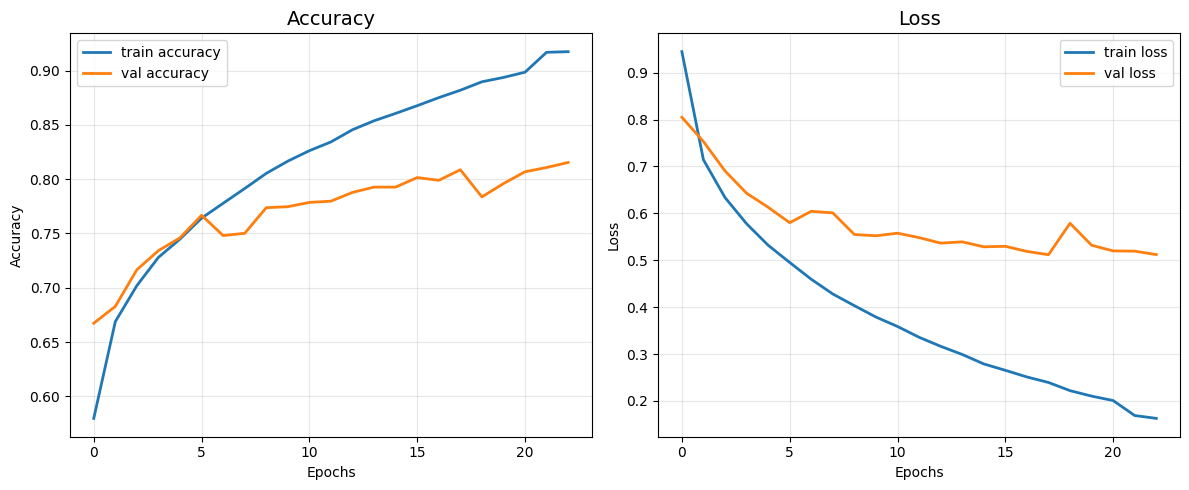

Train Accuracy: 0.9175
Validation Accuracy: 0.8154


In [13]:
# Minimal improvements to existing plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='val accuracy', linewidth=2)
plt.title('Accuracy', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss', linewidth=2)
plt.plot(history.history['val_loss'], label='val loss', linewidth=2)
plt.title('Loss', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Train Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

In [14]:
# Evaluate the model on the test dataset
test_results = model.evaluate(test_ds)
test_loss = test_results[0]
test_accuracy = test_results[1]

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

542/542 ━━━━━━━━━━━━━━━━━━━━ 36s 66ms/step - accuracy: 0.8920 - loss: 0.2886
Test Loss: 0.525160551071167
Test Accuracy: 0.8054978251457214


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Raw predictions: [9.3224800e-01 5.3293283e-11 9.7854703e-04 6.6366613e-02 1.5933189e-09
 4.0680254e-04]
Prediction: Healthy (Confidence: 0.9322)


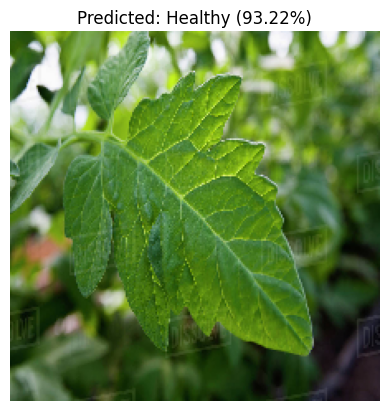

In [15]:
# Load and preprocess your custom image
from keras.utils import load_img, img_to_array
import numpy as np

# Path to your custom image - Update these paths as needed
custom_image_path = f"../data/custom/image.png" 

try:
    img = load_img(custom_image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    # img_array = img_array / 255.0 # Normalization is in the model

    predictions = model.predict(img_array)
    
    print("Raw predictions:", predictions[0])
    
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_idx]
    confidence = np.max(predictions[0])

    print(f"Prediction: {predicted_class} (Confidence: {confidence:.4f})")
    
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class} ({confidence:.2%})")
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"Could not load or process custom image: {e}")

In [16]:
# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import numpy as np

# Get predictions for test set
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = []
for _, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)

# Calculate metrics
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"Weighted F1 Score: {f1:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

542/542 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step
Weighted F1 Score: 0.8061
Weighted Precision: 0.8092
Weighted Recall: 0.8055

Classification Report:
                        precision    recall  f1-score   support

               Healthy       0.95      0.97      0.96      1314
             Leaf_Mold       0.90      0.94      0.92        96
           Leaf_blight       0.81      0.70      0.75      1056
    Septoria_leaf_spot       0.76      0.78      0.77      1314
     Verticillium_wilt       0.54      0.63      0.58       330
Yellow_Leaf_Curl_Virus       0.61      0.65      0.63       219

              accuracy                           0.81      4329
             macro avg       0.76      0.78      0.77      4329
          weighted avg       0.81      0.81      0.81      4329



2025-12-30 12:54:59.672832: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
# Training Run Logger
import json
import datetime
import os

# Create logs directory if it doesn't exist
os.makedirs(LOGS_DIR, exist_ok=True)

# Calculate training time
try:
    training_time_seconds = training_end_time - training_start_time
except NameError:
    epochs_completed = len(history.history['accuracy'])
    estimated_time_per_epoch = 60 
    training_time_seconds = epochs_completed * estimated_time_per_epoch

training_time_minutes = training_time_seconds / 60
training_time_hours = training_time_minutes / 60

# Prepare training log data
training_log = {
    "timestamp": datetime.datetime.now().isoformat(),
    "hyperparameters": {
        "batch_size": BATCH_SIZE,
        "img_side_length": IMG_SIDE_LENGTH,
        "epochs": EPOCHS,
        "learning_rate": LR,
        "buffer_size": BUFFER_SIZE,
        "label_mode": LABEL_MODE,
        "class_weights": str(CLASS_WEIGHTS),
        "data_augmentation": "None (Pre-augmented dataset)",
        "base_model": "MobileNetV2",
        "base_model_trainable": False,
        "optimizer": "Adam",
        "loss": "categorical_crossentropy",
        "dropout_rate": 0.3,
        "dense_layer_units": IMG_SIDE_LENGTH
    },
    "dataset_info": {
        "data_dir": DATA_DIR,
        "class_names": class_names,
        "total_classes": len(class_names)
    },
    "results": {
        "final_train_accuracy": float(history.history['accuracy'][-1]),
        "final_val_accuracy": float(history.history['val_accuracy'][-1]),
        "final_train_loss": float(history.history['loss'][-1]),
        "final_val_loss": float(history.history['val_loss'][-1]),
        "best_val_accuracy": float(max(history.history['val_accuracy'])),
        "best_val_loss": float(min(history.history['val_loss'])),
        "epochs_trained": len(history.history['accuracy']),
        "test_accuracy": float(test_accuracy),
        "test_loss": float(test_loss),
        "test_f1_score_weighted": float(f1),
        "test_precision_weighted": float(precision),
        "test_recall_weighted": float(recall)    
    },
    "training_history": {
        "accuracy": [float(x) for x in history.history['accuracy']],
        "val_accuracy": [float(x) for x in history.history['val_accuracy']],
        "loss": [float(x) for x in history.history['loss']],
        "val_loss": [float(x) for x in history.history['val_loss']]
    }
}

# Save to JSON file with timestamp
timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
log_filename = f"{LOGS_DIR}/training_log_{timestamp_str}.json"

with open(log_filename, 'w') as f:
    json.dump(training_log, f, indent=2)

print(f"Training log saved to: {log_filename}")

# Print summary
print("\n=== TRAINING SUMMARY ===")
print(f"Model: MobileNetV2 (frozen) + Dense({IMG_SIDE_LENGTH}) + Dense({num_classes})")
print(f"Training Time: {training_log['training_time']['formatted'] if 'training_time' in training_log else 'N/A'}")
print(f"Final Training Accuracy: {training_log['results']['final_train_accuracy']:.4f}")
print(f"Final Validation Accuracy: {training_log['results']['final_val_accuracy']:.4f}")
print(f"Test Accuracy: {training_log['results']['test_accuracy']:.4f}")
print(f"Test F1 Score: {training_log['results']['test_f1_score_weighted']:.4f}")

Training log saved to: ../logs/disease_detection_multiclass/training_log_20251230_125459.json

=== TRAINING SUMMARY ===
Model: MobileNetV2 (frozen) + Dense(224) + Dense(6)
Training Time: N/A
Final Training Accuracy: 0.9175
Final Validation Accuracy: 0.8154
Test Accuracy: 0.8055
Test F1 Score: 0.8061


In [18]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
model_path = f"{PROJECT_DIR}/models/tomato_disease_multiclass_model.tflite"
with open(model_path, "wb") as f:
    f.write(tflite_model)

print(f"Model successfully converted to TFLite format and saved to {model_path}")

INFO:tensorflow:Assets written to: /tmp/tmp88x8yv_7/assets


INFO:tensorflow:Assets written to: /tmp/tmp88x8yv_7/assets


Saved artifact at '/tmp/tmp88x8yv_7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  126936183134288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126936183135248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126936183136400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126936183135440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126936183134864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126936183135056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126936183137360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126936183138128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126936183137744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126936183134096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1269361831

W0000 00:00:1767079511.450237    5582 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1767079511.450657    5582 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-12-30 12:55:11.451988: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp88x8yv_7
2025-12-30 12:55:11.465436: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-30 12:55:11.465451: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp88x8yv_7
I0000 00:00:1767079511.593452    5582 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-12-30 12:55:11.618507: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-30 12:55:12.406890: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp88x8yv_7
2025-12-30 12:55:12.627482: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 